## Nonlinear MPC Following Another Vehicle With Minimum Distance

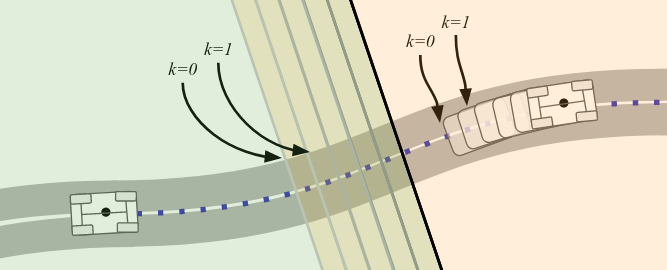

The model has state and input:
\begin{gather*}
z = \begin{bmatrix}x\\ y\\ v\\ \psi\end{bmatrix},\quad
u = \begin{bmatrix}a\\ \delta_f\end{bmatrix},\quad
\end{gather*}

The 4 states are:
* $x$ and $y$, the car's position in the world frame
* $v$, the car's velocity
* $\psi$, the angle of the car's centerline in the world frame


The two control signals are $a$, the acceleration command, and $\delta_f$, the front steering angle (in radians).

$\beta$ is the angle between the car's centerline and its velocity vector. It is not really a state, but a function of $\delta_f$.

The nonlinear model is:
\begin{gather*}
\begin{bmatrix}
\dot x\\ \dot y\\ \dot v\\ \dot\psi
%\\ \dot\beta
\end{bmatrix} =
\begin{bmatrix}
v\cos(\psi + \beta)
\\
v\sin(\psi + \beta)
\\
a
\\
\frac{v}{l_r}\sin(\beta)
%\\
%\frac{v}{l_f + l_r}\tan(\delta_f) - \frac{v}{l_r}\sin(\beta)
\end{bmatrix}, \quad \beta = \tan^{-1}\Big(\frac{l_r}{l_r + l_f}\tan(\delta_f)\Big)
\end{gather*}


## Set up the road data

In [1]:
# Library dependencies
import casadi
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl

# Local dependencies
from trajectory_planner import TrajectoryPlanner
from roadrunner_2        import Roadrunner, Segment, OutOfRoadPointsException

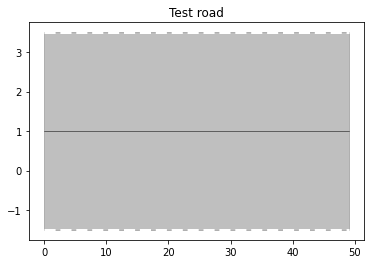

In [2]:
# Generates a straight test_road
test_road = np.ones((50,2))
for i in range(50):
    test_road[i,0] = i

left_width = 2.5*np.ones(np.size(test_road)//2)
right_width = 2.5*np.ones(np.size(test_road)//2)

# Plot the test road
def plot_road(ax, road, left_width, right_width):
    plt.title("Test road")
    ax.plot(road[:,0], road[:,1]+right_width, color="white", linestyle="--", linewidth=3)
    ax.plot(road[:,0], road[:,1]-left_width, color="white", linestyle="--", linewidth=3)
    ax.fill(np.concatenate([road[:,0], np.flip(road[:,0]), road[0:1,0]]),
             np.concatenate([road[:,1]+right_width, np.flip(road[:,1]-left_width), road[0:1,1]+right_width[0:1]]),
            color="grey", alpha=0.5)
    ax.plot(road[:,0], road[:,1], color="black", linewidth=0.5)
    return ax

fig, ax = plt.subplots(1,1)
plot_road(ax, test_road, left_width, right_width)
plt.show()

## Initialize the car and road model

In [3]:
# Initialize the car model with 0.075 second steps and 30 step lookahead
params = {"step":0.075,
          "N":30,
          "n":4, # 4 states
          "m":2, # 2 control inputs
         }
planner = TrajectoryPlanner(**params)

In [4]:
n_test_road_pts,_ = np.shape(test_road)

roadrunner = Roadrunner(road_center = test_road, # Road centerline points
                        left_width  = left_width,
                        right_width = right_width,
                        P           = np.size(left_width)-1,
                       start_pct = 0.0, end_pct = 1.0) # Number of points to try curve-fitting at a time

### Set up the desired_speed function

In [5]:
# Speed to start at
DESIRED_SPEED = 4.0

def desired_speed(x, y, k):
    return DESIRED_SPEED

### Set up the driveable_corridor function

In [6]:
def driveable_corridor(x, y, s):
    state = roadrunner.save_state()
    step = roadrunner.advance_xy(np.array([x,y]))
    xy, psi, dl, dr = roadrunner.evaluate(s, full_data=True)
    xy = np.reshape(xy, 2)
    roadrunner.reset(**state)
    return xy[0], xy[1], psi, dl, dr

### Set up the constraint_generator
It returns a function that is <= 0 for safe states

In [7]:
x0_front, y0_front = 12.0, 1.0 # initial position of car ahead
v_front = 3.75 # m/s # car ahead is moving slower than us
minimum_distance = 8.0 # m, minimum distance between cars
step = 0.075 # timestep
def constraint_generator(z, k):
    def g(x, y, v, psi, index):
        x0, y0 = x0_front+(index+k)*step*v_front - minimum_distance, y0_front
        return -((y-y0)**2 + (x-x0)**2)*np.cos(np.arctan2(y0-y, x0-x))
    return g

### Initial conditions

In [8]:
xy, angle, dl, dr = roadrunner.evaluate(full_data=True)
ic = np.array([xy[0,0], xy[0,1], desired_speed(xy[0,0], xy[0,1], 0), angle])
print("Initial conditions: x, y, v, phi =", ic)

Initial conditions: x, y, v, phi = [2.28698896e-20 1.00000000e+00 4.00000000e+00 0.00000000e+00]


## Run the MPC algorithm

### Cost weights

In [9]:
weights = {
       "accuracy":1.0,
           "jerk":100.0,
"steering change":100.0,
       "acceleration":0.0,
}

# Controls the NUMBER of iterations to run the MPC algorithm.
n_runs = 120

## Initialize the trajectory planner

In [10]:
roadrunner.reset()
# start a bit ahead of the first point to have space for looking back on the road
roadrunner.advance(2)

xy = np.reshape(roadrunner.evaluate(),(2,))
ic = [xy[0], xy[1], desired_speed(0, xy[0], xy[1]), roadrunner.get_angle()]

z_est, u_est = planner.generate_first_estimate(ic, driveable_corridor, desired_speed, constraint_generator)
planner.mpcprob.model.state_estimate =z_est
planner.mpcprob.model.control_estimate =u_est

planner.setup_to_save_data(n_runs)

planner.z0 = ic
estimated_path, _, _ = planner.generate_path_estimate(driveable_corridor, desired_speed, constraint_generator)
planner.initialize_first_mpc_problem(estimated_path)

<IPython.core.display.Javascript object>


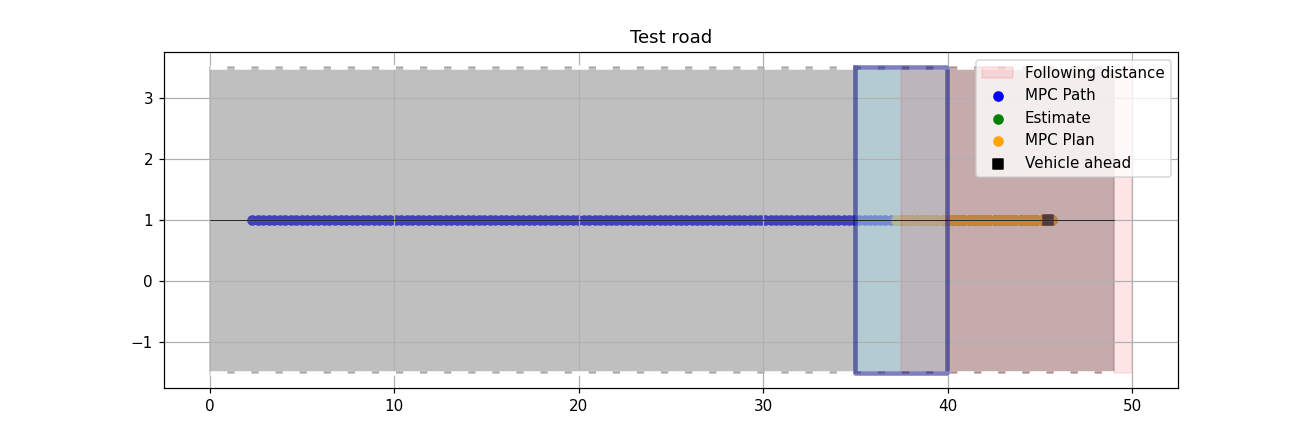


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equa

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  27  2.1656765e-01 7.01e-14 2.81e-01  -3.8 1.29e-05    -  1.00e+00 1.00e+00h  1
  28  2.1655609e-01 6.48e-14 2.32e-03  -3.8 1.32e-06    -  1.00e+00 1.00e+00h  1
  29  2.1655648e-01 5.98e-14 1.20e-06  -3.8 4.44e-08    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.1643117e-01 6.66e-14 2.39e-01  -5.7 1.10e-04    -  1.00e+00 1.00e+00f  1
  31  2.1641910e-01 8.20e-14 1.66e-03  -5.7 1.37e-06    -  1.00e+00 1.00e+00h  1
  32  2.1641946e-01 8.12e-14 8.39e-07  -5.7 4.17e-08    -  1.00e+00 1.00e+00h  1
  33  2.1641762e-01 5.98e-14 3.73e-05  -8.6 1.37e-06    -  1.00e+00 1.00e+00h  1
  34  2.1641762e-01 4.91e-14 1.69e-10  -8.6 2.05e-10    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:   2.1641762302072262e-01    2.1641762302072262e-01
Dual infeasibility......:   1.6876278152722080e-10    1.6876278152722080e-10
Constraint viol

Advanced by 0.2984770582232174 to [[18.18465361  1.        ]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  28  1.1222904e+00 8.68e-14 5.35e-02  -2.5 1.29e-05   3.6 1.00e+00 1.00e+00h  1
  29  1.1222006e+00 3.60e-12 5.37e-02  -2.5 3.88e-05   3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.1221691e+00 7.33e-13 5.37e-02  -2.5 1.46e-05   3.6 1.00e+00 1.00e+00h  1
  31  1.1220847e+00 1.29e-10 5.36e-02  -2.5 4.36e-05   3.1 1.00e+00 1.00e+00f  1
  32  1.1220390e+00 3.89e-11 7.49e-02  -2.5 2.28e-05   3.5 1.00e+00 1.00e+00h  1
  33  1.1213933e+00 8.54e-08 1.93e+01  -2.5 1.07e-03   3.0 1.00e+00 1.00e+00f  1
  34  1.1063213e+00 4.49e-07 1.72e+00  -2.5 1.78e-02    -  1.00e+00 1.00e+00f  1
  35  1.1084703e+00 5.19e-08 1.57e+04  -2.5 2.43e-03    -  4.84e-01 1.00e+00h  1
  36  1.1121418e+00 2.16e-09 4.03e+00  -2.5 1.93e-04   2.6 1.00e+00 1.00e+00h  1
  37  1.1079177e+00 2.32e-08 2.88e+00  -2.5 1.30e-03    -  1.00e+00 1.00e+00f  1
  38  1.1100195e+00 3.64e-07 6.64e+02  -2.5 6.53e-03    -  8.31e-01 1.00e+00h  1
  39  1.1080033e+00 2.80e-07

  26  1.4312874e+00 3.33e-13 5.77e-02  -2.5 1.24e-05   3.7 1.00e+00 1.00e+00h  1
  27  1.4310630e+00 3.39e-11 5.95e-02  -2.5 3.82e-05   3.2 1.00e+00 1.00e+00f  1
  28  1.4309849e+00 1.18e-11 5.97e-02  -2.5 1.44e-05   3.6 1.00e+00 1.00e+00h  1
  29  1.4257948e+00 2.02e-08 3.42e+01  -2.5 1.22e-03   3.1 1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.4290382e+00 3.73e-09 3.95e+00  -2.5 2.93e-04   2.7 1.00e+00 1.00e+00h  1
  31  1.4116969e+00 3.64e-07 1.10e+01  -2.5 1.98e-02    -  1.00e+00 1.00e+00f  1
  32  1.4150935e+00 3.86e-07 5.58e+03  -2.5 6.71e-03    -  4.57e-01 1.00e+00h  1
  33  1.4180281e+00 2.61e-10 1.12e+00  -2.5 1.42e-04   2.2 1.00e+00 1.00e+00h  1
  34  1.4138969e+00 5.87e-08 2.01e+00  -2.5 2.50e-03    -  1.00e+00 1.00e+00f  1
  35  1.4154920e+00 4.07e-08 3.67e+00  -2.5 6.06e-03    -  1.00e+00 1.00e+00H  1
  36  1.4152293e+00 4.10e-10 4.28e-02  -2.5 2.10e-04    -  1.00e+00 1.00e+00h  1
  37  1.4153031e+00 1.06e-12

  64  1.7458748e+00 8.47e-10 1.85e+03  -2.5 2.73e-04   2.7 1.00e+00 2.50e-01f  3
  65  1.7454572e+00 2.27e-09 1.46e+01  -2.5 2.34e-03    -  1.00e+00 1.00e+00F  1
  66  1.7455066e+00 5.72e-10 3.60e+02  -2.5 1.39e-02    -  1.00e+00 3.12e-02f  6
  67  1.7457064e+00 2.94e-09 1.18e+03  -2.5 2.04e-02    -  7.24e-01 3.12e-02f  6
  68  1.7430363e+00 1.67e-10 1.85e-01  -2.5 1.14e-04   2.3 1.00e+00 1.00e+00h  1
  69  1.7430856e+00 4.01e-10 2.78e+03  -2.5 2.41e-02    -  3.16e-01 7.81e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.5555113e+00 8.59e-05 2.08e+03  -2.5 3.73e-02   1.8 1.14e-03 7.20e-02F  1
  71  1.5595258e+00 8.09e-05 3.65e+03  -2.5 3.03e-02    -  1.00e+00 1.16e-01f  3
  72  1.5528598e+00 8.41e-05 1.20e+03  -2.5 4.89e-03    -  1.00e+00 9.41e-02f  2
  73  1.5588276e+00 7.02e-05 6.66e+02  -2.5 1.07e-02    -  4.21e-01 3.01e-01h  1
  74  1.5639441e+00 6.58e-05 2.55e+02  -2.5 4.26e-03    -  1.00e+00 6.25e-02f  5
  75  1.6479649e+00 1.67e-05

  26  2.1256589e+00 8.15e-14 6.73e-02  -2.5 1.44e-05   3.7 1.00e+00 1.00e+00f  1
  27  2.1256098e+00 5.10e-14 6.78e-02  -2.5 5.44e-06   4.1 1.00e+00 1.00e+00h  1
  28  2.1254868e+00 3.12e-13 6.90e-02  -2.5 1.66e-05   3.6 1.00e+00 1.00e+00f  1
  29  2.1254438e+00 5.88e-14 6.93e-02  -2.5 6.26e-06   4.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.1253362e+00 1.44e-12 7.02e-02  -2.5 1.90e-05   3.6 1.00e+00 1.00e+00f  1
  31  2.1252986e+00 2.80e-13 7.05e-02  -2.5 7.16e-06   4.0 1.00e+00 1.00e+00h  1
  32  2.1252020e+00 1.53e-11 7.10e-02  -2.5 2.16e-05   3.5 1.00e+00 1.00e+00f  1
  33  2.1251656e+00 4.12e-12 7.09e-02  -2.5 8.10e-06   3.9 1.00e+00 1.00e+00h  1
  34  2.1250066e+00 8.47e-10 3.73e-01  -2.5 1.12e-04   3.5 1.00e+00 1.00e+00f  1
  35  2.1248480e+00 1.16e-10 3.15e-01  -2.5 4.05e-05   3.9 1.00e+00 1.00e+00f  1
  36  2.1239596e+00 2.29e-09 2.64e+00  -2.5 1.76e-04   3.4 1.00e+00 1.00e+00f  1
  37  2.0986160e+00 6.45e-08

  27  2.5058725e+00 2.20e-12 6.93e-02  -2.5 5.56e-06   4.1 1.00e+00 1.00e+00h  1
  28  2.5056658e+00 1.26e-10 1.80e-01  -2.5 4.34e-05   3.6 1.00e+00 1.00e+00f  1
  29  2.5055729e+00 2.83e-11 2.27e-01  -2.5 2.05e-05   4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.5050715e+00 1.43e-09 1.73e+00  -2.5 1.45e-04   3.6 1.00e+00 1.00e+00f  1
  31  2.5019511e+00 1.13e-08 1.77e+01  -2.5 3.77e-04   3.1 1.00e+00 1.00e+00f  1
  32  2.4994069e+00 5.33e-09 3.10e+00  -2.5 4.75e-04   2.6 1.00e+00 1.00e+00F  1
  33  2.4999143e+00 1.11e-10 2.29e+00  -2.5 4.20e-05   3.9 1.00e+00 1.00e+00h  1
  34  2.5021351e+00 3.02e-09 3.72e+00  -2.5 2.17e-04   3.5 1.00e+00 1.00e+00f  1
  35  2.4798458e+00 1.38e-07 2.02e+03  -2.5 2.34e-02    -  9.83e-01 1.00e+00f  1
  36  2.4849571e+00 1.76e-09 1.57e+01  -2.5 1.86e-04   3.0 1.00e+00 1.00e+00h  1
  37  2.4814698e+00 3.92e-10 3.23e+00  -2.5 2.18e-04    -  1.00e+00 1.00e+00f  1
  38  2.4818346e+00 9.98e-09

  26  2.9187674e+00 6.30e-12 2.87e-01  -2.5 1.73e-05   3.7 1.00e+00 1.00e+00h  1
  27  2.9186261e+00 1.80e-12 8.13e-02  -2.5 6.53e-06   4.1 1.00e+00 1.00e+00h  1
  28  2.9182568e+00 1.36e-10 1.96e-01  -2.5 4.52e-05   3.6 1.00e+00 1.00e+00f  1
  29  2.9181013e+00 3.47e-11 2.53e-01  -2.5 2.28e-05   4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.9173143e+00 2.24e-09 3.28e+00  -2.5 1.82e-04   3.6 1.00e+00 1.00e+00f  1
  31  2.7213537e+00 1.01e-04 1.70e+04  -2.5 3.14e-02    -  1.00e+00 6.35e-01f  1
  32  2.7291700e+00 9.45e-05 1.65e+04  -2.5 4.51e-03   3.1 4.04e-03 6.25e-02f  5
  33  2.8642872e+00 1.26e-05 6.14e+01  -2.5 4.62e-03   3.5 1.00e+00 1.00e+00h  1
  34  2.8899267e+00 7.01e-07 9.90e+03  -2.5 3.27e-03   3.0 8.50e-01 1.00e+00h  1
  35  2.8858609e+00 1.39e-08 4.06e-01  -2.5 7.43e-04   2.6 1.00e+00 1.00e+00f  1
  36  2.8824083e+00 1.43e-07 1.63e-01  -2.5 1.23e-02    -  1.00e+00 1.00e+00f  1
  37  2.8820141e+00 2.71e-09

  27  3.3380794e+00 1.03e-13 9.35e-02  -2.5 7.51e-06   4.1 1.00e+00 1.00e+00h  1
  28  3.3377215e+00 1.76e-12 1.94e-01  -2.5 2.31e-05   3.6 1.00e+00 1.00e+00f  1
  29  3.3375940e+00 4.46e-13 9.68e-02  -2.5 8.74e-06   4.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  3.3375471e+00 8.58e-14 9.70e-02  -2.5 3.28e-06   4.5 1.00e+00 1.00e+00h  1
  31  3.3374143e+00 2.20e-12 9.77e-02  -2.5 9.92e-06   4.0 1.00e+00 1.00e+00f  1
  32  3.3373651e+00 4.44e-13 9.78e-02  -2.5 3.72e-06   4.4 1.00e+00 1.00e+00h  1
  33  3.3372211e+00 1.55e-11 1.36e-01  -2.5 1.56e-05   3.9 1.00e+00 1.00e+00f  1
  34  3.3371652e+00 3.31e-12 1.68e-01  -2.5 7.20e-06   4.4 1.00e+00 1.00e+00h  1
  35  3.3369654e+00 1.34e-10 3.56e-01  -2.5 4.57e-05   3.9 1.00e+00 1.00e+00f  1
  36  3.3368719e+00 2.29e-11 3.88e-01  -2.5 1.87e-05   4.3 1.00e+00 1.00e+00f  1
  37  3.3364328e+00 4.92e-10 1.31e+00  -2.5 8.63e-05   3.8 1.00e+00 1.00e+00f  1
  38  3.3348317e+00 2.68e-09

  27  3.7667178e+00 5.45e-14 1.26e-01  -2.5 7.50e-06   4.1 1.00e+00 1.00e+00h  1
  28  3.7662254e+00 1.06e-12 3.86e-01  -2.5 2.30e-05   3.6 1.00e+00 1.00e+00f  1
  29  3.7660451e+00 3.29e-13 1.11e-01  -2.5 8.66e-06   4.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  3.7659779e+00 9.97e-14 9.60e-02  -2.5 3.25e-06   4.5 1.00e+00 1.00e+00h  1
  31  3.7657827e+00 2.67e-12 1.12e-01  -2.5 9.80e-06   4.0 1.00e+00 1.00e+00f  1
  32  3.7657090e+00 5.59e-13 9.63e-02  -2.5 3.67e-06   4.4 1.00e+00 1.00e+00h  1
  33  3.7654823e+00 3.18e-11 1.96e-01  -2.5 2.24e-05   3.9 1.00e+00 1.00e+00f  1
  34  3.7653891e+00 7.40e-12 2.54e-01  -2.5 1.09e-05   4.4 1.00e+00 1.00e+00f  1
  35  3.7649838e+00 4.33e-10 1.37e+00  -2.5 8.26e-05   3.9 1.00e+00 1.00e+00f  1
  36  3.7613835e+00 1.26e-08 4.98e+01  -2.5 4.26e-04   3.4 1.00e+00 1.00e+00f  1
  37  3.7631148e+00 5.70e-11 1.97e+00  -2.5 5.57e-05   3.8 1.00e+00 1.00e+00h  1
  38  3.7240466e+00 1.34e-06

  27  4.2039481e+00 9.19e-11 4.72e-01  -2.5 3.79e-05   4.1 1.00e+00 1.00e+00f  1
  28  4.2020718e+00 3.82e-09 1.51e+01  -2.5 2.40e-04   3.6 1.00e+00 1.00e+00f  1
  29  4.2026366e+00 1.10e-09 1.08e+01  -2.5 1.33e-04   3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.1517649e+00 1.19e-07 3.04e+04  -2.5 3.72e-02    -  6.78e-01 1.00e+00f  1
  31  4.1517880e+00 1.42e-10 1.79e+00  -2.5 5.64e-05   3.6 1.00e+00 1.00e+00h  1
  32  4.1515499e+00 6.91e-09 2.85e+01  -2.5 9.83e-04    -  1.00e+00 1.00e+00f  1
  33  4.1571607e+00 3.03e-06 3.79e+03  -2.5 1.89e-02    -  3.67e-01 1.00e+00f  1
  34  4.1563057e+00 6.05e-12 1.32e-01  -2.5 1.07e-04   3.1 1.00e+00 1.00e+00h  1
  35  4.1553527e+00 2.28e-10 1.04e-02  -2.5 1.95e-04    -  1.00e+00 1.00e+00f  1
  36  4.1509237e+00 6.35e-07 4.70e+02  -3.8 1.44e-02    -  1.00e+00 5.99e-01f  1
  37  4.1492622e+00 3.70e-07 1.16e+01  -3.8 6.53e-03    -  1.00e+00 1.00e+00f  1
  38  4.1483957e+00 2.62e-08

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  25  6.0164933e+00 1.04e-13 6.02e-01  -2.5 1.15e-05   4.1 1.00e+00 1.00e+00f  1
  26  6.0163034e+00 9.58e-14 2.23e-01  -2.5 4.40e-06   4.6 1.00e+00 1.00e+00f  1
  27  6.0157314e+00 9.80e-14 6.67e-01  -2.5 1.33e-05   4.1 1.00e+00 1.00e+00f  1
  28  6.0155067e+00 1.16e-13 2.74e-01  -2.5 5.23e-06   4.5 1.00e+00 1.00e+00f  1
  29  6.0147557e+00 7.14e-13 1.24e+00  -2.5 1.76e-05   4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  6.0144271e+00 2.38e-13 4.77e-01  -2.5 7.81e-06   4.5 1.00e+00 1.00e+00f  1
  31  6.0128396e+00 9.02e-11 4.06e+00  -2.5 3.87e-05   4.0 1.00e+00 1.00e+00f  1
  32  6.0119240e+00 6.95e-13 5.25e+00  -2.5 2.26e-05   4.4 1.00e+00 1.00e+00f  1
  33  6.0086533e+00 2.13e-09 6.54e+01  -2.5 1.89e-04   3.9 1.00e+00 1.00e+00f  1
  34  5.9260411e+00 2.83e-07 1.25e+01  -2.5 4.66e-02    -  1.00e+00 1.00e+00f  1
  35  5.9267918e+00 2.44e-10 5.49e+00  -2.5 1.46e-04    -  1.00e+00 1.00e+00h  1
  36  5.9270863e+00 4.61e-12

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  29  7.8732010e+00 8.21e-14 1.52e+00  -2.5 2.33e-05   4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  7.8727643e+00 7.00e-14 5.73e-01  -2.5 9.07e-06   4.5 1.00e+00 1.00e+00f  1
  31  7.8711540e+00 8.05e-14 4.19e+00  -2.5 3.31e-05   4.0 1.00e+00 1.00e+00f  1
  32  7.8702669e+00 8.29e-14 1.82e+00  -2.5 1.88e-05   4.4 1.00e+00 1.00e+00f  1
  33  7.8698722e+00 8.41e-14 6.10e-01  -2.5 8.47e-06   4.8 1.00e+00 1.00e+00f  1
  34  7.8679919e+00 2.11e-13 3.23e+01  -2.5 4.12e-05   4.4 1.00e+00 1.00e+00f  1
  35  7.6678115e+00 1.17e-09 4.91e+00  -2.5 6.93e-02    -  1.00e+00 1.00e+00f  1
  36  7.6684185e+00 2.42e-12 3.56e-01  -2.5 4.88e-04    -  1.00e+00 1.00e+00h  1
  37  7.6683869e+00 7.65e-14 9.64e-04  -2.5 1.20e-04    -  1.00e+00 1.00e+00h  1
  38  7.6660337e+00 8.57e-14 2.80e+02  -5.7 4.88e-03    -  9.99e-01 1.00e+00f  1
  39  7.6652569e+00 4.34e-10 4.68e+03  -5.7 1.23e-04    -  1.00e+00 8.56e-01h  1
iter    objective    inf_pr 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  25  9.1297642e+00 8.91e-14 8.66e-01  -2.5 3.38e-06   5.0 1.00e+00 1.00e+00f  1
  26  9.1291954e+00 8.49e-13 7.39e-01  -2.5 1.11e-05   4.6 1.00e+00 1.00e+00f  1
  27  9.1261967e+00 1.35e-10 1.55e+01  -2.5 6.07e-05   4.1 1.00e+00 1.00e+00f  1
  28  9.1199123e+00 2.72e-08 1.18e+02  -2.5 4.19e-04   3.6 1.00e+00 1.00e+00f  1
  29  9.1146001e+00 8.38e-08 1.35e+02  -2.5 8.41e-04   3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  9.0984664e+00 5.33e-07 2.79e+02  -2.5 1.56e-03   2.7 1.00e+00 1.00e+00f  1
  31  9.1129005e+00 1.20e-07 1.67e+01  -2.5 5.46e-04   4.0 1.00e+00 1.00e+00h  1
  32  9.1200184e+00 1.20e-08 2.52e+01  -2.5 1.53e-04   4.4 1.00e+00 1.00e+00h  1
  33  9.1217432e+00 1.19e-09 2.32e+01  -2.5 1.49e-04   3.9 1.00e+00 1.00e+00f  1
  34  9.1232300e+00 1.79e-10 7.81e-01  -2.5 9.10e-05   3.5 1.00e+00 1.00e+00f  1
  35  8.8943080e+00 4.91e-07 2.49e+04  -2.5 7.39e-02    -  7.56e-01 1.00e+00f  1
  36  8.8939302e+00 6.92e-10

  25  9.5287840e+00 1.83e-13 1.98e+00  -2.5 2.21e-05   4.1 1.00e+00 1.00e+00f  1
  26  9.5283361e+00 7.43e-14 5.21e-01  -2.5 8.75e-06   4.6 1.00e+00 1.00e+00f  1
  27  9.5268625e+00 1.69e-12 2.87e+00  -2.5 2.77e-05   4.1 1.00e+00 1.00e+00f  1
  28  9.5261894e+00 6.61e-13 1.13e+00  -2.5 1.28e-05   4.5 1.00e+00 1.00e+00f  1
  29  9.5220891e+00 2.57e-10 4.02e+01  -2.5 8.19e-05   4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  9.2721196e+00 3.51e-07 3.04e+01  -2.5 7.58e-02    -  1.00e+00 1.00e+00f  1
  31  9.2709203e+00 1.41e-08 4.46e+01  -2.5 9.06e-04    -  1.00e+00 1.00e+00h  1
  32  9.2681427e+00 4.57e-08 7.12e+01  -2.5 4.08e-04    -  1.00e+00 1.00e+00f  1
  33  9.2711573e+00 7.38e-09 8.67e+00  -2.5 3.41e-04   3.6 1.00e+00 1.00e+00h  1
  34  9.2740052e+00 3.52e-10 6.35e+00  -2.5 3.09e-04    -  1.00e+00 1.00e+00H  1
  35  9.2740632e+00 1.59e-12 1.28e+00  -2.5 1.66e-05    -  1.00e+00 1.00e+00h  1
  36  9.2741210e+00 1.18e-13

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  26  1.0497867e+01 2.41e-13 1.52e+00  -2.5 1.65e-05   4.6 1.00e+00 1.00e+00f  1
  27  1.0489723e+01 9.35e-09 1.92e+02  -2.5 1.59e-04   4.1 1.00e+00 1.00e+00f  1
  28  1.0357429e+01 3.91e-08 9.04e+00  -2.5 5.52e-02    -  1.00e+00 1.00e+00f  1
  29  1.0358774e+01 7.99e-11 1.62e+00  -2.5 5.91e-04    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.0358763e+01 3.91e-13 3.68e-02  -2.5 1.41e-04    -  1.00e+00 1.00e+00h  1
  31  1.0355687e+01 2.47e-13 1.09e+01  -3.8 5.86e-03    -  1.00e+00 1.00e+00f  1
  32  1.0355002e+01 1.32e-13 7.40e-01  -3.8 2.24e-04    -  1.00e+00 1.00e+00h  1
  33  1.0355132e+01 1.10e-13 1.48e-02  -3.8 2.54e-06    -  1.00e+00 1.00e+00h  1
  34  1.0355133e+01 1.15e-13 2.85e-06  -3.8 1.29e-08    -  1.00e+00 1.00e+00h  1
  35  1.0354983e+01 1.08e-13 3.90e-02  -5.7 3.51e-04    -  1.00e+00 1.00e+00f  1
  36  1.0354981e+01 7.14e-14 7.45e-06  -5.7 8.28e-07    -  1.00e+00 1.00e+00h  1
  37  1.0354979e+01 9.53e-14

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  26  1.1701073e+01 1.35e-13 6.46e+00  -2.5 8.96e-05   3.7 1.00e+00 1.00e+00f  1
  27  1.1699546e+01 8.68e-14 3.44e+00  -2.5 3.11e-05   4.1 1.00e+00 1.00e+00f  1
  28  1.1698850e+01 7.52e-14 6.60e-01  -2.5 1.29e-05   4.5 1.00e+00 1.00e+00f  1
  29  1.1696481e+01 8.07e-14 5.89e+00  -2.5 4.16e-05   4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.1695219e+01 1.08e-13 2.62e+00  -2.5 2.21e-05   4.5 1.00e+00 1.00e+00f  1
  31  1.1694660e+01 9.71e-14 7.82e-01  -2.5 9.93e-06   4.9 1.00e+00 1.00e+00f  1
  32  1.1692136e+01 2.88e-13 4.43e+01  -2.5 4.59e-05   4.4 1.00e+00 1.00e+00f  1
  33  1.1330814e+01 2.33e-09 7.15e+00  -2.5 8.39e-02    -  1.00e+00 1.00e+00f  1
  34  1.1332767e+01 2.44e-11 3.15e-01  -2.5 2.71e-03    -  1.00e+00 1.00e+00h  1
  35  1.1331974e+01 9.85e-14 6.64e-03  -2.5 1.66e-03    -  1.00e+00 1.00e+00h  1
  36  1.1328385e+01 9.04e-14 4.18e+02  -5.7 6.79e-03    -  9.98e-01 1.00e+00f  1
  37  1.1327717e+01 2.56e-10

  58  1.1632551e+01 1.25e-12 2.84e-02  -3.8 4.03e-06   2.8 1.00e+00 1.00e+00h  1
  59  1.1632522e+01 1.21e-11 4.11e-03  -3.8 1.35e-05   2.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.1632515e+01 5.15e-11 2.19e-02  -3.8 3.56e-05   1.9 1.00e+00 1.00e+00h  1
  61  1.1632495e+01 2.98e-10 1.93e-01  -3.8 1.04e-04   1.4 1.00e+00 1.00e+00h  1
  62  1.1632402e+01 4.01e-09 4.10e+00  -3.8 4.47e-04   0.9 1.00e+00 1.00e+00h  1
  63  1.1632240e+01 4.19e-09 6.89e+00  -3.8 3.95e-04   1.4 1.00e+00 1.00e+00h  1
  64  1.1631781e+01 1.68e-08 3.47e+01  -3.8 6.30e-04   1.8 1.00e+00 1.00e+00h  1
  65  1.1629950e+01 1.78e-08 4.76e+05  -3.8 1.04e-03   3.1 1.00e+00 2.68e-01f  1
  66  1.1625421e+01 3.78e-08 1.02e+01  -3.8 7.51e-04    -  1.00e+00 1.00e+00f  1
  67  1.1626800e+01 1.90e-09 5.42e+00  -3.8 6.65e-05    -  1.00e+00 1.00e+00h  1
  68  1.1627245e+01 7.36e-12 1.24e+00  -3.8 2.84e-05    -  1.00e+00 1.00e+00h  1
  69  1.1627369e+01 2.11e-13

  62  1.1919234e+01 7.19e-11 2.32e+00  -3.8 4.21e-05   3.2 1.00e+00 1.00e+00f  1
  63  1.1918830e+01 6.81e-09 7.97e+00  -3.8 3.08e-04   2.7 1.00e+00 1.00e+00f  1
  64  1.1917625e+01 6.52e-09 2.04e+01  -3.8 2.99e-04   3.1 1.00e+00 1.00e+00f  1
  65  1.1908040e+01 9.42e-08 2.39e+02  -3.8 7.52e-04   3.5 1.00e+00 1.00e+00f  1
  66  1.1913384e+01 2.11e-08 1.28e+01  -3.8 3.80e-04   4.0 1.00e+00 1.00e+00h  1
  67  1.1908704e+01 5.28e-08 1.12e+02  -3.8 7.43e-04   3.5 1.00e+00 1.00e+00f  1
  68  1.1912236e+01 1.78e-08 4.02e+01  -3.8 4.00e-04    -  1.00e+00 1.00e+00H  1
  69  1.1911675e+01 1.58e-08 1.96e+01  -3.8 2.19e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.1913451e+01 4.22e-09 3.45e+00  -3.8 9.45e-05    -  1.00e+00 1.00e+00h  1
  71  1.1914499e+01 4.24e-12 1.16e+00  -3.8 1.92e-05    -  1.00e+00 1.00e+00h  1
  72  1.1914631e+01 9.86e-14 5.93e-02  -3.8 2.42e-06    -  1.00e+00 1.00e+00h  1
  73  1.1914633e+01 7.94e-14

  58  1.2195144e+01 1.06e-09 7.54e-01  -3.8 2.13e-04   1.0 1.00e+00 1.00e+00h  1
  59  1.2194980e+01 1.26e-08 5.87e+04  -3.8 3.72e-03   0.6 1.00e+00 2.24e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.2194690e+01 2.64e-09 8.09e+00  -3.8 2.49e-04   1.9 1.00e+00 1.00e+00h  1
  61  1.2194031e+01 1.09e-08 2.91e+01  -3.8 4.15e-04   2.3 1.00e+00 1.00e+00f  1
  62  1.2191331e+01 2.68e-09 1.21e+01  -3.8 2.04e-04   3.6 1.00e+00 1.00e+00f  1
  63  1.2189728e+01 3.08e-08 4.35e+00  -3.8 7.20e-04    -  1.00e+00 1.00e+00f  1
  64  1.2189893e+01 2.61e-13 1.81e-01  -3.8 7.69e-06    -  1.00e+00 1.00e+00h  1
  65  1.2189902e+01 7.41e-14 6.95e-04  -3.8 5.00e-07    -  1.00e+00 1.00e+00h  1
  66  1.2189749e+01 1.18e-13 3.54e-02  -5.7 4.31e-04    -  1.00e+00 1.00e+00f  1
  67  1.2189748e+01 9.76e-14 5.76e-06  -5.7 1.49e-06    -  1.00e+00 1.00e+00h  1
  68  1.2189746e+01 1.08e-13 5.39e-06  -8.6 5.39e-06    -  1.00e+00 1.00e+00h  1
  69  1.2189746e+01 1.06e-13

  59  1.2451549e+01 9.77e-09 1.91e+01  -3.8 4.11e-04   3.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.2453405e+01 3.15e-09 5.92e-01  -3.8 3.94e-04    -  1.00e+00 1.00e+00H  1
  61  1.2453476e+01 1.01e-13 1.68e-02  -3.8 6.47e-06    -  1.00e+00 1.00e+00h  1
  62  1.2453477e+01 9.61e-14 2.75e-06  -3.8 1.56e-08    -  1.00e+00 1.00e+00h  1
  63  1.2453323e+01 7.21e-14 3.50e-02  -5.7 4.45e-04    -  1.00e+00 1.00e+00f  1
  64  1.2453322e+01 1.09e-13 5.57e-06  -5.7 1.64e-06    -  1.00e+00 1.00e+00h  1
  65  1.2453320e+01 6.52e-14 5.32e-06  -8.6 5.56e-06    -  1.00e+00 1.00e+00h  1
  66  1.2453320e+01 8.24e-14 1.74e-09  -8.6 2.55e-10    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 66

                                   (scaled)                 (unscaled)
Objective...............:   1.2453319692437164e+01    1.2453319692437164e+01
Dual infeasibility......:   1.7441053046240995e-09    1.7441053046240995e-09
Constraint viol

  62  1.2702342e+01 4.59e-08 5.12e+04  -3.8 3.34e-04   4.0 1.00e+00 2.50e-01f  3
  63  1.2700117e+01 3.49e-08 9.76e+01  -3.8 7.53e-04   3.5 1.00e+00 1.00e+00f  1
  64  1.2704654e+01 3.67e-09 1.34e+01  -3.8 3.77e-04    -  1.00e+00 1.00e+00H  1
  65  1.2705552e+01 9.33e-13 5.21e-01  -3.8 1.60e-05    -  1.00e+00 1.00e+00h  1
  66  1.2705628e+01 9.54e-14 3.53e-03  -3.8 1.36e-06    -  1.00e+00 1.00e+00h  1
  67  1.2705475e+01 7.41e-14 3.42e-02  -5.7 4.60e-04    -  1.00e+00 1.00e+00f  1
  68  1.2705473e+01 9.23e-14 5.29e-06  -5.7 1.79e-06    -  1.00e+00 1.00e+00h  1
  69  1.2705471e+01 1.17e-13 5.25e-06  -8.6 5.74e-06    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.2705471e+01 1.07e-13 1.94e-09  -8.6 2.80e-10    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 70

                                   (scaled)                 (unscaled)
Objective...............:   1.2705471306272438e+01    1.2705471306272438e+01
Dual infeas

  61  1.2950788e+01 1.00e-08 3.37e+00  -3.8 3.69e-04   2.7 1.00e+00 1.00e+00f  1
  62  1.2949040e+01 1.43e-08 5.43e+02  -3.8 4.47e-04   3.2 1.00e+00 9.97e-01f  1
  63  1.2945863e+01 2.37e-09 1.53e+01  -3.8 2.57e-04    -  1.00e+00 1.00e+00f  1
  64  1.2946612e+01 1.27e-12 2.39e+00  -3.8 1.32e-05    -  1.00e+00 1.00e+00h  1
  65  1.2946646e+01 1.45e-13 3.70e-02  -3.8 2.65e-06    -  1.00e+00 1.00e+00h  1
  66  1.2946648e+01 8.07e-14 2.49e-05  -3.8 1.28e-07    -  1.00e+00 1.00e+00h  1
  67  1.2946493e+01 1.13e-13 3.41e-02  -5.7 4.74e-04    -  1.00e+00 1.00e+00f  1
  68  1.2946492e+01 1.16e-13 5.23e-06  -5.7 1.96e-06    -  1.00e+00 1.00e+00h  1
  69  1.2946490e+01 8.57e-14 5.18e-06  -8.6 5.92e-06    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.2946490e+01 1.29e-13 8.85e-11  -8.6 3.06e-10    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 70

                                   (scaled)                 (unscaled)
Objecti

  62  1.3182257e+01 1.26e-08 1.30e+01  -3.8 9.31e-04   0.5 1.00e+00 1.00e+00h  1
  63  1.3182071e+01 7.99e-10 2.68e+00  -3.8 1.46e-04   1.8 1.00e+00 1.00e+00h  1
  64  1.3181986e+01 3.64e-10 8.20e-01  -3.8 9.00e-05   2.3 1.00e+00 1.00e+00h  1
  65  1.3181692e+01 7.73e-09 9.93e+04  -3.8 1.52e-03   1.8 1.00e+00 2.66e-01f  2
  66  1.3181131e+01 7.68e-10 4.96e+00  -3.8 9.93e-05   3.1 1.00e+00 1.00e+00h  1
  67  1.3180621e+01 5.74e-10 2.76e+00  -3.8 9.03e-05   3.5 1.00e+00 1.00e+00f  1
  68  1.3180186e+01 1.97e-10 7.16e-01  -3.8 5.41e-05   4.0 1.00e+00 1.00e+00f  1
  69  1.3176715e+01 1.69e-08 6.22e+05  -3.8 1.82e-03   3.5 1.00e+00 2.81e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.3173584e+01 7.59e-08 3.35e+01  -3.8 1.12e-03    -  1.00e+00 1.00e+00f  1
  71  1.3175175e+01 6.48e-09 6.39e+00  -3.8 1.26e-04    -  1.00e+00 1.00e+00h  1
  72  1.3176660e+01 3.63e-10 1.31e+00  -3.8 2.60e-05    -  1.00e+00 1.00e+00h  1
  73  1.3176905e+01 1.49e-13

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

 102  1.3606553e+01 8.24e-14 3.57e-04  -3.8 3.65e-07    -  1.00e+00 1.00e+00h  1
 103  1.3606396e+01 9.24e-14 3.29e-02  -5.7 5.17e-04    -  1.00e+00 1.00e+00f  1
 104  1.3606395e+01 1.18e-13 4.80e-06  -5.7 2.53e-06    -  1.00e+00 1.00e+00h  1
 105  1.3606393e+01 7.95e-14 5.00e-06  -8.6 6.48e-06    -  1.00e+00 1.00e+00h  1
 106  1.3606393e+01 9.39e-14 1.12e-09  -8.6 3.96e-10    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 106

                                   (scaled)                 (unscaled)
Objective...............:   1.3606393058637433e+01    1.3606393058637433e+01
Dual infeasibility......:   1.1220464557482046e-09    1.1220464557482046e-09
Constraint violation....:   9.3924867883288243e-14    9.3924867883288243e-14
Complementarity.........:   2.5059035607196007e-09    2.5059035607196007e-09
Overall NLP error.......:   7.4672751245326895e-10    2.5059035607196007e-09


Number of objective function evaluations             = 212
Number of objective gradient evaluations      

  26  1.4488764e+01 2.45e-13 2.13e-01  -1.7 4.55e-05   3.7 1.00e+00 1.00e+00f  1
  27  1.4487248e+01 4.90e-12 2.12e-01  -1.7 1.36e-04   3.2 1.00e+00 1.00e+00f  1
  28  1.4486684e+01 8.74e-13 2.12e-01  -1.7 5.11e-05   3.6 1.00e+00 1.00e+00f  1
  29  1.4485021e+01 2.08e-11 2.12e-01  -1.7 1.53e-04   3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.4484401e+01 3.81e-12 2.11e-01  -1.7 5.72e-05   3.6 1.00e+00 1.00e+00f  1
  31  1.4482562e+01 1.14e-10 2.10e-01  -1.7 1.71e-04   3.1 1.00e+00 1.00e+00f  1
  32  1.4481872e+01 2.18e-11 2.10e-01  -1.7 6.40e-05   3.5 1.00e+00 1.00e+00f  1
  33  1.4479739e+01 1.71e-09 2.08e-01  -1.7 1.91e-04   3.0 1.00e+00 1.00e+00f  1
  34  1.4478726e+01 4.34e-10 2.21e-01  -1.7 7.59e-05   3.5 1.00e+00 1.00e+00f  1
  35  1.4471630e+01 8.74e-08 8.88e+00  -1.7 1.07e-03   3.0 1.00e+00 1.00e+00f  1
  36  1.4439478e+01 5.89e-08 1.25e+01  -1.7 1.10e-03   2.5 1.00e+00 1.00e+00f  1
  37  1.4140043e+01 1.08e-06

  26  1.4659012e+01 1.79e-12 2.11e-01  -1.7 4.51e-05   3.7 1.00e+00 1.00e+00f  1
  27  1.4657614e+01 3.64e-11 2.10e-01  -1.7 1.35e-04   3.2 1.00e+00 1.00e+00f  1
  28  1.4657093e+01 6.47e-12 2.10e-01  -1.7 5.06e-05   3.6 1.00e+00 1.00e+00f  1
  29  1.4655546e+01 1.55e-10 2.09e-01  -1.7 1.51e-04   3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.4654960e+01 2.83e-11 2.09e-01  -1.7 5.66e-05   3.6 1.00e+00 1.00e+00f  1
  31  1.4653073e+01 1.96e-09 2.07e-01  -1.7 1.68e-04   3.1 1.00e+00 1.00e+00f  1
  32  1.4652142e+01 4.42e-10 2.51e-01  -1.7 7.65e-05   3.5 1.00e+00 1.00e+00f  1
  33  1.4646427e+01 3.77e-08 3.99e+00  -1.7 7.03e-04   3.0 1.00e+00 1.00e+00f  1
  34  1.4602224e+01 2.81e-07 3.93e+01  -1.7 1.98e-03   2.6 1.00e+00 1.00e+00f  1
  35  1.4617064e+01 1.81e-07 4.56e+03  -1.7 2.45e-03   2.1 8.43e-01 1.00e+00f  1
  36  1.4639744e+01 8.05e-09 7.41e+00  -1.7 7.63e-04   2.5 1.00e+00 1.00e+00f  1
  37  1.4315182e+01 4.12e-06

  27  1.4758880e+01 7.09e-11 6.16e+00  -2.5 3.42e-05   4.1 1.00e+00 1.00e+00f  1
  28  1.4757766e+01 1.54e-11 5.80e-01  -2.5 1.75e-05   4.5 1.00e+00 1.00e+00f  1
  29  1.4753147e+01 1.02e-10 1.98e+01  -2.5 7.42e-05   4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.4752251e+01 7.39e-11 1.90e+00  -2.5 3.70e-05   4.5 1.00e+00 1.00e+00f  1
  31  1.4750332e+01 7.08e-10 1.54e+01  -2.5 1.10e-04   4.0 1.00e+00 1.00e+00f  1
  32  1.4360068e+01 2.10e-07 1.52e+03  -2.5 9.41e-02    -  1.00e+00 9.62e-01f  1
  33  1.4394766e+01 3.27e-08 6.85e+00  -2.5 2.85e-02    -  1.00e+00 1.00e+00f  1
  34  1.4362015e+01 4.99e-09 3.99e+00  -2.5 2.47e-02    -  1.00e+00 1.00e+00f  1
  35  1.4358658e+01 1.09e-10 3.84e-01  -2.5 5.35e-03    -  1.00e+00 1.00e+00h  1
  36  1.4358642e+01 9.61e-14 8.81e-05  -2.5 2.32e-05    -  1.00e+00 1.00e+00h  1
  37  1.4352797e+01 1.03e-13 5.84e+02  -5.7 9.18e-03    -  9.97e-01 1.00e+00f  1
  38  1.4352177e+01 1.87e-10

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Advanced by 0.2845234623128671 to [[31.2553782  1.       ]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr

  28  1.5864018e+01 1.87e-13 2.86e-01  -1.7 6.90e-05   3.6 1.00e+00 1.00e+00f  1
  29  1.5860577e+01 5.47e-12 2.86e-01  -1.7 2.07e-04   3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.5859318e+01 1.07e-12 2.86e-01  -1.7 7.76e-05   3.6 1.00e+00 1.00e+00f  1
  31  1.5855706e+01 4.45e-11 2.86e-01  -1.7 2.33e-04   3.1 1.00e+00 1.00e+00f  1
  32  1.5854373e+01 8.98e-12 2.86e-01  -1.7 8.72e-05   3.5 1.00e+00 1.00e+00f  1
  33  1.5850467e+01 7.19e-10 2.85e-01  -1.7 2.61e-04   3.0 1.00e+00 1.00e+00f  1
  34  1.5848944e+01 1.51e-10 2.84e-01  -1.7 9.73e-05   3.5 1.00e+00 1.00e+00f  1
  35  1.5787298e+01 1.18e-06 1.17e+02  -1.7 4.78e-03   3.0 1.00e+00 1.00e+00F  1
  36  1.5817666e+01 5.44e-08 1.20e+01  -1.7 1.17e-03   2.5 1.00e+00 1.00e+00h  1
  37  1.5231059e+01 6.90e-06 1.34e+03  -1.7 7.13e-02    -  8.87e-01 1.00e+00f  1
  38  1.5324348e+01 2.38e-08 1.05e+01  -1.7 1.52e-03   2.0 1.00e+00 1.00e+00f  1
  39  1.5259658e+01 1.44e-07

  28  1.5667089e+01 1.74e-13 3.22e+00  -2.5 2.43e-05   4.5 1.00e+00 1.00e+00f  1
  29  1.5666403e+01 1.23e-13 9.58e-01  -2.5 1.08e-05   4.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.5663570e+01 1.67e-11 4.70e+01  -2.5 4.53e-05   4.5 1.00e+00 1.00e+00f  1
  31  1.5246277e+01 8.13e-08 1.51e+04  -2.5 9.97e-02    -  1.00e+00 8.95e-01f  1
  32  1.5280833e+01 9.55e-09 6.19e+00  -2.5 2.47e-02    -  1.00e+00 1.00e+00f  1
  33  1.5242758e+01 3.99e-10 4.27e+00  -2.5 2.60e-02    -  1.00e+00 1.00e+00f  1
  34  1.5238046e+01 6.22e-11 5.65e-01  -2.5 6.47e-03    -  1.00e+00 1.00e+00h  1
  35  1.5238004e+01 1.13e-13 3.81e-04  -2.5 6.22e-05    -  1.00e+00 1.00e+00h  1
  36  1.5230937e+01 1.82e-13 6.47e+02  -5.7 1.01e-02    -  9.97e-01 1.00e+00f  1
  37  1.5230311e+01 1.73e-10 3.12e+03  -5.7 1.20e-03    -  1.00e+00 9.01e-01h  1
  38  1.5230365e+01 1.09e-13 1.00e-02  -5.7 1.15e-04    -  1.00e+00 1.00e+00h  1
  39  1.5230366e+01 1.01e-13

  59  1.5358811e+01 5.38e-09 7.85e+00  -3.8 5.34e-04   0.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.5358372e+01 3.01e-08 5.30e+01  -3.8 9.87e-04   1.4 1.00e+00 1.00e+00h  1
  61  1.5350154e+01 1.83e-08 1.26e+02  -3.8 3.04e-04   3.6 1.00e+00 1.00e+00f  1
  62  1.5352544e+01 1.59e-09 1.86e+01  -3.8 7.41e-04    -  1.00e+00 1.00e+00H  1
  63  1.5353089e+01 4.29e-12 9.86e-01  -3.8 1.00e-05    -  1.00e+00 1.00e+00h  1
  64  1.5353115e+01 1.02e-13 3.06e-03  -3.8 4.20e-07    -  1.00e+00 1.00e+00h  1
  65  1.5352949e+01 1.06e-13 2.98e-02  -5.7 6.77e-04    -  1.00e+00 1.00e+00f  1
  66  1.5352948e+01 1.07e-13 3.92e-06  -5.7 5.54e-06    -  1.00e+00 1.00e+00h  1
  67  1.5352946e+01 8.98e-14 4.50e-06  -8.6 8.53e-06    -  1.00e+00 1.00e+00h  1
  68  1.5352946e+01 1.40e-13 3.09e-10  -8.6 8.80e-10    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 68

                                   (scaled)                 (unscaled)
Objecti

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  89  1.5972072e+01 8.18e-14 6.49e-01  -5.7 8.54e-11    -  1.00e+00 3.81e-06h 19
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.5972072e+01 8.18e-14 6.49e-01  -5.7 8.54e-11    -  1.00e+00 3.81e-06h 19
  91  1.5972072e+01 1.42e-13 1.73e-09  -5.7 8.54e-11    -  1.00e+00 1.00e+00w  1
  92  1.5972070e+01 1.31e-13 4.32e-06  -8.6 9.58e-06    -  1.00e+00 1.00e+00h  1
  93  1.5972070e+01 1.24e-13 2.84e-10  -8.6 1.23e-09    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 93

                                   (scaled)                 (unscaled)
Objective...............:   1.5972069800234435e+01    1.5972069800234435e+01
Dual infeasibility......:   2.8391866635502083e-10    2.8391866635502083e-10
Constraint violation....:   1.2367884494324244e-13    1.2367884494324244e-13
Complementarity.........:   2.5059035670755974e-09    2.5059035670755974e-09
Overall NLP error.......:   6.9267369837702386e-10    2.5059035670755974e-09


Number of objective funct

  59  1.6175009e+01 5.11e-05 1.26e+02  -2.5 5.99e-02    -  1.00e+00 6.48e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.6101233e+01 8.43e-06 1.34e+01  -2.5 3.11e-02    -  1.00e+00 1.00e+00f  1
  61  1.6085883e+01 3.15e-07 2.04e+00  -2.5 5.59e-03    -  1.00e+00 1.00e+00h  1
  62  1.6084870e+01 3.18e-08 1.85e-01  -2.5 1.85e-03    -  1.00e+00 1.00e+00h  1
  63  1.6084746e+01 2.19e-11 2.90e-04  -2.5 4.88e-05    -  1.00e+00 1.00e+00h  1
  64  1.6073015e+01 2.17e-06 3.46e+02  -3.8 2.58e-02    -  1.00e+00 6.27e-01f  1
  65  1.6067444e+01 2.28e-06 2.70e+01  -3.8 1.64e-02    -  1.00e+00 1.00e+00f  1
  66  1.6065677e+01 7.42e-07 1.21e+03  -3.8 3.20e-03    -  1.00e+00 6.95e-01h  1
  67  1.6064944e+01 4.68e-08 8.24e+00  -3.8 2.21e-03    -  1.00e+00 1.00e+00f  1
  68  1.6064673e+01 2.10e-08 6.51e+00  -3.8 1.50e-03    -  1.00e+00 1.00e+00h  1
  69  1.6064528e+01 5.43e-08 2.59e+01  -3.8 2.43e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

  64  1.6146869e+01 4.69e-08 8.20e+00  -3.8 2.21e-03    -  1.00e+00 1.00e+00f  1
  65  1.6146598e+01 2.05e-08 6.30e+00  -3.8 1.49e-03    -  1.00e+00 1.00e+00h  1
  66  1.6146459e+01 4.37e-08 2.05e+01  -3.8 2.18e-03    -  1.00e+00 1.00e+00h  1
  67  1.6146254e+01 2.27e-11 2.18e-01  -3.8 1.89e-05   2.2 1.00e+00 1.00e+00h  1
  68  1.6146273e+01 1.34e-10 7.92e-02  -3.8 6.01e-05   1.7 1.00e+00 1.00e+00h  1
  69  1.6146229e+01 9.79e-10 8.55e-01  -3.8 2.00e-04   1.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.6146039e+01 1.28e-08 7.08e+05  -3.8 2.67e-02   0.7 1.00e+00 2.84e-02f  2
  71  1.6145694e+01 2.89e-09 9.97e+00  -3.8 2.45e-04   2.1 1.00e+00 1.00e+00h  1
  72  1.6145271e+01 4.29e-09 6.60e+04  -3.8 4.65e-04   2.5 1.00e+00 4.04e-01f  2
  73  1.6143397e+01 2.63e-08 1.91e+05  -3.8 1.05e-03   2.9 1.00e+00 5.43e-01f  1
  74  1.6142138e+01 6.42e-10 4.84e+00  -3.8 1.11e-04   4.2 1.00e+00 1.00e+00f  1
  75  1.6119243e+01 4.24e-07

  26  2.2858494e+02 1.33e-13 5.52e+01  -1.0 9.45e-02   2.8 1.00e+00 1.00e+00f  1
  27  2.1999564e+02 9.03e-14 5.25e+01  -1.0 3.37e-02   3.2 1.00e+00 1.00e+00f  1
  28  2.1689549e+02 9.88e-14 5.17e+01  -1.0 1.24e-02   3.6 1.00e+00 1.00e+00f  1
  29  2.0819966e+02 1.20e-12 4.90e+01  -1.0 3.54e-02   3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.0507161e+02 2.99e-13 4.81e+01  -1.0 1.30e-02   3.6 1.00e+00 1.00e+00f  1
  31  2.0391665e+02 1.18e-13 4.77e+01  -1.0 4.85e-03   4.0 1.00e+00 1.00e+00f  1
  32  2.0054375e+02 7.63e-13 4.67e+01  -1.0 1.42e-02   3.5 1.00e+00 1.00e+00f  1
  33  1.9930007e+02 1.30e-13 4.63e+01  -1.0 5.29e-03   3.9 1.00e+00 1.00e+00f  1
  34  1.9567677e+02 2.14e-12 4.52e+01  -1.0 1.55e-02   3.5 1.00e+00 1.00e+00f  1
  35  1.9434282e+02 3.58e-13 4.48e+01  -1.0 5.76e-03   3.9 1.00e+00 1.00e+00f  1
  36  1.9046659e+02 6.60e-12 4.36e+01  -1.0 1.68e-02   3.4 1.00e+00 1.00e+00f  1
  37  1.8904189e+02 1.12e-12

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Advanced by 0.2845234623128671 to [[35.49692036  1.        ]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      688

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      270
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      150

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  93  1.6715987e+01 1.14e-13 3.00e-10  -8.6 1.96e-09    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 93

                                   (scaled)                 (unscaled)
Objective...............:   1.6715986732248187e+01    1.6715986732248187e+01
Dual infeasibility......:   3.0000535389262950e-10    3.0000535389262950e-10
Constraint violation....:   1.1368683772161603e-13    1.1368683772161603e-13
Complementarity.........:   2.5059035779580989e-09    2.5059035779580989e-09
Overall NLP error.......:   6.7794524458911595e-10    2.5059035779580989e-09


Number of objective function evaluations             = 105
Number of objective gradient evaluations             = 94
Number of equality constraint evaluations            = 105
Number of inequality constraint evaluations          = 105
Number of equality constraint Jacobian evaluations   = 94
Number of inequality constraint Jacobian evaluations = 94
Number of Lagrangian Hessian evaluations             = 93
Total CPU secs in IPO

  65  1.6794425e+01 3.21e-09 5.98e-02  -2.5 5.65e-04    -  1.00e+00 1.00e+00h  1
  66  1.6794264e+01 3.71e-11 1.99e-04  -2.5 6.27e-05    -  1.00e+00 1.00e+00h  1
  67  1.6781082e+01 2.35e-06 3.24e+02  -3.8 2.68e-02    -  1.00e+00 6.31e-01f  1
  68  1.6774728e+01 2.52e-06 2.71e+01  -3.8 1.73e-02    -  1.00e+00 1.00e+00f  1
  69  1.6772790e+01 8.30e-07 1.15e+03  -3.8 3.71e-03    -  1.00e+00 6.96e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.6771972e+01 4.77e-08 7.86e+00  -3.8 2.23e-03    -  1.00e+00 1.00e+00f  1
  71  1.6771707e+01 1.73e-08 4.87e+00  -3.8 1.36e-03    -  1.00e+00 1.00e+00h  1
  72  1.6771614e+01 1.12e-08 4.77e+00  -3.8 1.10e-03    -  1.00e+00 1.00e+00h  1
  73  1.6771577e+01 2.30e-11 5.18e-02  -3.8 3.30e-05   0.8 1.00e+00 1.00e+00h  1
  74  1.6771569e+01 9.49e-11 5.00e-02  -3.8 9.25e-05   0.3 1.00e+00 1.00e+00h  1
  75  1.6771530e+01 1.44e-09 8.83e-01  -3.8 3.82e-04  -0.2 1.00e+00 1.00e+00h  1
  76  1.6771502e+01 4.93e-10

In [11]:
%matplotlib notebook

# store the polygon boundary for each step, so we can plot them later
polygon_boundaries = np.zeros((n_runs+params["N"],4,2))

# Set up for plotting
fig_traj = plt.figure(figsize=(12,4))
ax_traj = fig_traj.add_subplot(111)

plt.ion()
fig_traj.show()

states = ax_traj.plot(planner.x_true[0], planner.x_true[1], color="red")[0]
plt.xlim([0,100])

fig_traj.canvas.draw()

k = 0

try:
    while k < n_runs:

        estimated_path, left_widths, right_widths = planner.generate_path_estimate(driveable_corridor, desired_speed, constraint_generator)
        
        # Solve the MPC problem
        problem = planner.build_mpc_problem(estimated_path, left_widths, right_widths, weights, constraint_generator(planner.z0, k))
        xk_opt, uk_opt, sol = planner.solve_mpc_problem(problem)
        
        # for plotting
        planner.centers[:,k+1] = planner.mpcprob.x_center_plot[:,1]

        # Save the next state x_k+1 and control u_k+1
        for i in range(params["n"]):
            planner.x_plan[i,k+1] = xk_opt[i][1]
        for i in range(params["m"]):
            planner.u_plan[i,k] = uk_opt[i][1]
        _,p = planner.mpcprob.bound_x(estimated_path[0,0], estimated_path[1,0], estimated_path[3,0], left_widths[0], right_widths[0])
        planner.polygon_boundaries[k,:,:] = p
        
        planner.x_true[:,k+1] = planner.apply_control(planner.u_plan[:,k])
        planner.z0 = planner.x_true[:,k+1]
        
        planner.initialize_nth_mpc_problem(xk_opt, uk_opt)
    
    
        # Advance the roadrunner to our new state at k+1
        step_xy = roadrunner.advance_xy(planner.x_true[0:2,k+1])

        print("Advanced by", step_xy,"to", roadrunner.evaluate())

        # for plotting
        ax_traj.clear()
        plot_road(ax_traj, test_road, left_width, right_width)
        
        # Plot the MPC car's current position
        ax_traj.scatter(planner.x_true[0,:k], planner.x_true[1,:k], color="blue", label="MPC Path")
        
        xy = np.reshape(roadrunner.evaluate(),(2,1))
        # Plot the polygon fill
        ax_traj.fill(planner.polygon_boundaries[k,:,0], planner.polygon_boundaries[k,:,1], "lightblue", alpha=0.5)
        # Plot the line around each polygon
        ax_traj.plot(np.concatenate([planner.polygon_boundaries[k,:,0],planner.polygon_boundaries[k,0:1,0]]),
                np.concatenate([planner.polygon_boundaries[k,:,1],planner.polygon_boundaries[k,0:1,1]]),
                color="navy", alpha=0.5)
        
        # Plot the estimated path (helps with debugging)
        ax_traj.scatter(estimated_path[0,:], estimated_path[1,:], color="green", label="Estimate")
        
        # Plot the planned path
        ax_traj.scatter(xk_opt[0], xk_opt[1], color="orange", label="MPC Plan")
        
        # Plot the car ahead
        x_front, y_front = x0_front+(k)*step*v_front, y0_front
        ax_traj.scatter(x_front, y_front, color="black", marker="s", s=50, label="Vehicle ahead")
        # Plot the keep-out region (minimum distance from vehicle)
        min_x = x_front-minimum_distance
        ax_traj.fill(np.array([min_x, min_x, 50, 50, min_x]), np.array([-1.5, 3.5, 3.5, -1.5, -1.5]), alpha=0.1, color="red",label="Following distance")
        plt.legend()
        fig_traj.canvas.draw()
        # Done!

        if not sol['success']: # it failed
            print("FAILED: ipopt returned status", sol['success'], "\n", sol['return_status'])
            raise ValueError("ipopt failed and I need to make a better exception name")
        
        k += 1

except OutOfRoadPointsException as e:
    print(e)
    planner.x_plan = planner.x_plan[:,:k] # Cut the vectors shorter so they don't have unitialized values
    planner.u_plan = planner.u_plan[:,:k-1]  
    planner.x_true = planner.x_true[:,k]
    planner.centers = planner.centers[:,k]
    # store the polygon boundary for each step, so we can plot them later
    polygon_boundaries = polygon_boundaries[:k+N,:,:]

finally:
    fig_traj.canvas.draw()

In [12]:
# turn interactive plotting off
plt.ioff()
k

120

## Control signals: acceleration and steering angle

<IPython.core.display.Javascript object>


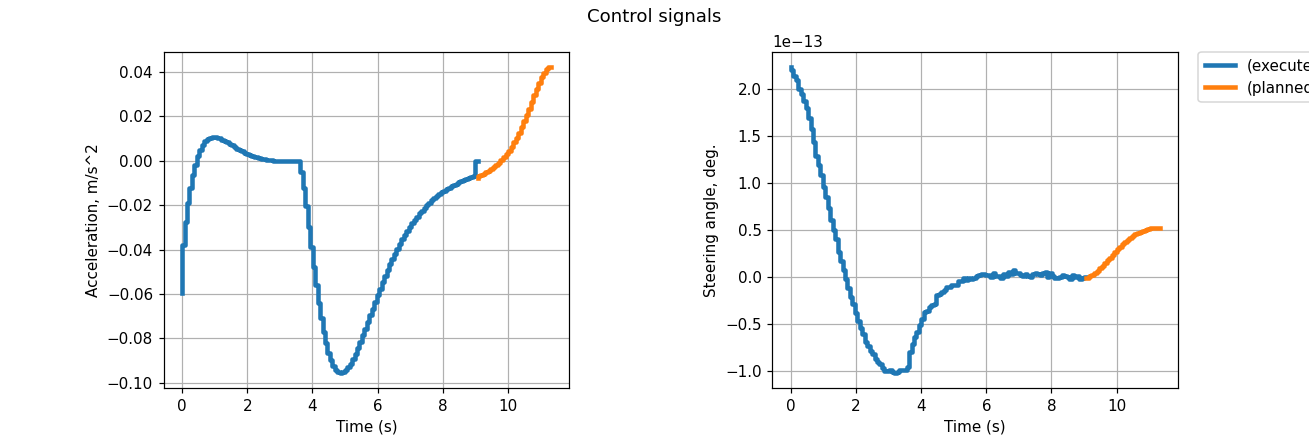

In [13]:
from KinematicBicycleCar import plot_u
u_plt, u_ax1, u_ax2 = plot_u(planner.u_plan, planner.mpcprob.u_opt, params["step"], params["N"])

plt.show()

<IPython.core.display.Javascript object>


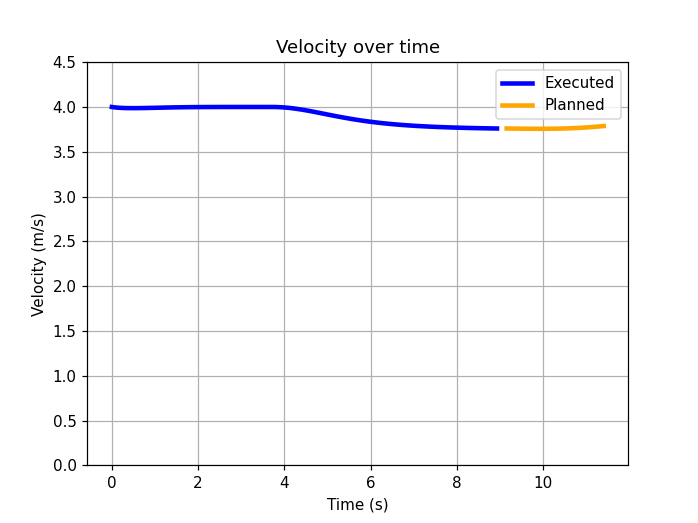

In [14]:
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(np.size(planner.x_plan[2,:k]))*planner.step, planner.x_plan[2,:k], color="blue", label="Executed")
ax.plot(np.arange(np.size(planner.mpcprob.x_opt[2,:]))*planner.step + np.size(planner.x_plan[2,:])*planner.step, planner.mpcprob.x_opt[2,:], color="orange", label="Planned")
plt.ylim(0, 4.5)
plt.legend()
plt.ylabel("Velocity (m/s)"); plt.xlabel("Time (s)")
plt.title("Velocity over time")
plt.show()